# How to deal with out-of-memory data


## Pandas + SQL
We use a nearly 10GB dataset containing NYC's 311 complaints since 2010 to demonstrate. The data can be downloaded here: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9. The orginial dataset contains 19.6M records with 41 columns.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import datetime as dt

We first look at what the observations are like:

In [2]:
tmp = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', nrows=2)

In [30]:
pd.to_datetime(tmp['Closed Date'],errors='coerce', infer_datetime_format=True)

0   2016-11-30 02:32:46
1   2016-12-01 11:38:17
Name: Closed Date, dtype: datetime64[ns]

In [2]:
display(pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', nrows=2).head())

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,34887213,11/29/2016 11:17:07 PM,11/30/2016 02:32:46 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10472,1237 ELDER AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.829622,-73.879425,"(40.82962235195856, -73.87942543545233)"
1,34887215,11/29/2016 07:41:03 AM,12/01/2016 11:38:17 AM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,11201,86 BERGEN STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.686511,-73.989940,"(40.686510876191235, -73.98994003433391)"


If we try to load the whole dataset at once, it will raise the memory error after minutes' of running:

In [4]:
%timeit dt311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv') # memory error

MemoryError: 

Thus,we need to read the dataset by trunks and select the useful subset we are interested in at the same time.

In [75]:
disk_engine = create_engine('sqlite:///NYC_311.db')

In [18]:
start = dt.datetime.now()
chunksize = 100
j = 0
index_start = 1

for df in pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', chunksize=chunksize, iterator=True, encoding='utf-8', header=0):
    
    df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) # Remove spaces from columns

    df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], errors='coerce', infer_datetime_format=True) # Convert to datetimes
    df['ClosedDate'] = pd.to_datetime(df['ClosedDate'], errors='coerce', infer_datetime_format=True)

    df.index += index_start

    # Remove the un-interesting columns
    columns = ['Agency', 'CreatedDate', 'ClosedDate', 'ComplaintType', 'Descriptor',
               'CreatedDate', 'ClosedDate', 'TimeToCompletion', 'City']

    for c in df.columns:
        if c not in columns:
            df = df.drop(c, axis=1)    
    
    j+=1
    if j%200 == 0:
        print('{} seconds: completed {} rows'.format((dt.datetime.now() - start).seconds, j*chunksize))

    df.to_sql('data', disk_engine, if_exists='append') # Connect the trunk to the database
    index_start = df.index[-1] + 1

15 seconds: completed 20000 rows
32 seconds: completed 40000 rows
47 seconds: completed 60000 rows
64 seconds: completed 80000 rows
80 seconds: completed 100000 rows
96 seconds: completed 120000 rows
112 seconds: completed 140000 rows
127 seconds: completed 160000 rows
143 seconds: completed 180000 rows
160 seconds: completed 200000 rows
177 seconds: completed 220000 rows
193 seconds: completed 240000 rows
209 seconds: completed 260000 rows
226 seconds: completed 280000 rows
244 seconds: completed 300000 rows
261 seconds: completed 320000 rows
278 seconds: completed 340000 rows
295 seconds: completed 360000 rows
312 seconds: completed 380000 rows
329 seconds: completed 400000 rows
346 seconds: completed 420000 rows
363 seconds: completed 440000 rows
379 seconds: completed 460000 rows
396 seconds: completed 480000 rows
411 seconds: completed 500000 rows
427 seconds: completed 520000 rows
444 seconds: completed 540000 rows
460 seconds: completed 560000 rows
477 seconds: completed 580000 

3988 seconds: completed 4520000 rows
4006 seconds: completed 4540000 rows
4022 seconds: completed 4560000 rows
4040 seconds: completed 4580000 rows
4057 seconds: completed 4600000 rows
4074 seconds: completed 4620000 rows
4092 seconds: completed 4640000 rows
4108 seconds: completed 4660000 rows
4126 seconds: completed 4680000 rows
4143 seconds: completed 4700000 rows
4159 seconds: completed 4720000 rows
4177 seconds: completed 4740000 rows
4195 seconds: completed 4760000 rows
4212 seconds: completed 4780000 rows
4230 seconds: completed 4800000 rows
4248 seconds: completed 4820000 rows
4265 seconds: completed 4840000 rows
4281 seconds: completed 4860000 rows
4298 seconds: completed 4880000 rows
4317 seconds: completed 4900000 rows
4334 seconds: completed 4920000 rows
4351 seconds: completed 4940000 rows
4368 seconds: completed 4960000 rows
4385 seconds: completed 4980000 rows
4402 seconds: completed 5000000 rows
4418 seconds: completed 5020000 rows
4435 seconds: completed 5040000 rows
4

7891 seconds: completed 8960000 rows
7908 seconds: completed 8980000 rows
7925 seconds: completed 9000000 rows
7941 seconds: completed 9020000 rows
7958 seconds: completed 9040000 rows
7975 seconds: completed 9060000 rows
7991 seconds: completed 9080000 rows
8008 seconds: completed 9100000 rows
8025 seconds: completed 9120000 rows
8042 seconds: completed 9140000 rows
8058 seconds: completed 9160000 rows
8075 seconds: completed 9180000 rows
8091 seconds: completed 9200000 rows
8108 seconds: completed 9220000 rows
8125 seconds: completed 9240000 rows
8142 seconds: completed 9260000 rows
8158 seconds: completed 9280000 rows
8175 seconds: completed 9300000 rows
8191 seconds: completed 9320000 rows
8208 seconds: completed 9340000 rows
8225 seconds: completed 9360000 rows
8241 seconds: completed 9380000 rows
8258 seconds: completed 9400000 rows
8275 seconds: completed 9420000 rows
8292 seconds: completed 9440000 rows
8309 seconds: completed 9460000 rows
8325 seconds: completed 9480000 rows
8

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 3027-03-30 00:00:00

The databased is saved as `NYC_311.db` and can be read directly in the future. We can then analyze the dataset using the database we acquired. For example, we can investigate which department receives the most complaints:

In [19]:
pd.read_sql_query('SELECT COUNT(*) as `num_of_records`'
                 'FROM data ', disk_engine)

,num_of_records
0,12995000


In [24]:
pd.read_sql_query('SELECT * FROM data ORDER BY -ClosedDate LIMIT 1',disk_engine)

,index,CreatedDate,ClosedDate,Agency,ComplaintType,Descriptor,City
0,94,2016-11-29 18:03:42.000000,None,DOHMH,Day Care,Other,BRONX


In [21]:
pd.read_sql_query('SELECT CreatedDate FROM data ORDER BY CreatedDate LIMIT 1',disk_engine)

,CreatedDate
0,2010-01-01 00:00:00.000000


In [44]:
complaints_by_agency = pd.read_sql_query('SELECT Agency, COUNT(*) as `num_complaints`'
                       'FROM data '
                       'GROUP BY Agency '
                       'ORDER BY -num_complaints '
                       'LIMIT 10', disk_engine) # notice there is space at the end of each line of SQL command

In [32]:
import matplotlib.pyplot as plt

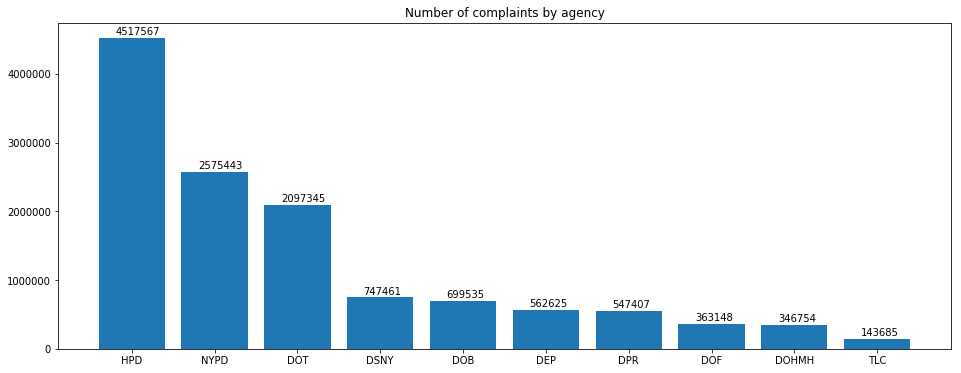

In [54]:
ind = range(complaints_by_agency.shape[0])
plt.figure(figsize=(16,6))
plt.bar(x=ind,height=complaints_by_agency['num_complaints'])
for k in ind:
    plt.text(k-0.2, complaints_by_agency['num_complaints'][k]+50000,str(complaints_by_agency['num_complaints'][k]))
plt.title('Number of complaints by agency')
plt.xticks(ind,complaints_by_agency['Agency'])
plt.show()

We can see that Housing and Development Dept receives the most complaints. 

We can also investigate what are the most common complaints:

In [58]:
most_common_complaints = pd.read_sql_query('SELECT ComplaintType, COUNT(*) as `num_complaints` '
                       'FROM data '
                       'GROUP BY `ComplaintType` '
                       'ORDER BY -num_complaints LIMIT 10', disk_engine)


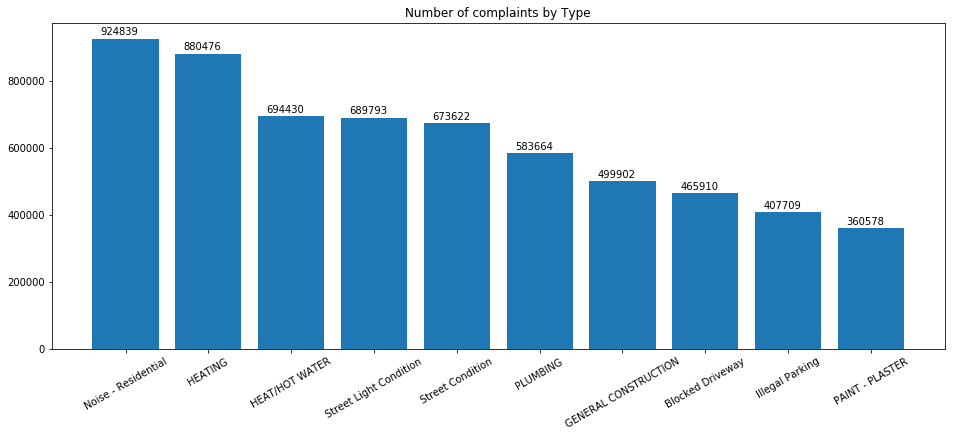

In [67]:
ind = range(most_common_complaints.shape[0])
plt.figure(figsize=(16,6))
plt.bar(x=ind,height=most_common_complaints['num_complaints'])
for k in ind:
    plt.text(k-0.3, most_common_complaints['num_complaints'][k]+10000,str(most_common_complaints['num_complaints'][k]))
plt.title('Number of complaints by Type')
plt.xticks(ind,most_common_complaints['ComplaintType'], rotation=30)
plt.show()

We see that the Noise issue is the most common complaints.

# Read data using datatable

We now go back to the Airline on-time performance data.

In [84]:
tic = dt.datetime.now()
DT_panda = pd.read_csv('Airline2008.csv',header=0)
toc = dt.datetime.now()
print(toc-tic)

0:00:37.985026


In [86]:
import sys
sys.getsizeof(DT_panda)
DT_panda.shape

(7009728, 29)

https://datatable.readthedocs.io/en/latest/using-datatable.html
## benchmark comparison:
https://h2oai.github.io/db-benchmark/

# Save your memory by specifying the datatype
https://www.dataquest.io/blog/pandas-big-data/


# Fast Computing Using PySpark
https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html
https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html
https://www.slideshare.net/PyData/improving-pandas-and-pyspark-performance-and-interoperability-with-apache-arrow
https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html#apache-arrow-in-spark

# Parallel Computing
file:///D:/Cloud/Dropbox/annie's%20slds%20class%20notes/read%20big%20data%20in%20r/tutorial-parallel-basics-master/parallel-basics.html

# Other fancy stuffs:
`mmap`: https://pymotw.com/2/mmap/


# Acknoledgement and References
This tutorial is motivated by several useful posts:
https://plot.ly/ipython-notebooks/big-data-analytics-with-pandas-and-sqlite/
Common Operations by data.table and Pandas: https://datascience-enthusiast.com/R/pandas_datatable.html
